In [1]:
import cellMorphHelper

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import datetime
import os

%matplotlib inline
from IPython import display

from skimage.io import imread, imsave
from skimage.measure import label, find_contours, regionprops
from skimage.color import label2rgb

/stor/home/tj8243/miniconda3/envs/computerVision/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions
Continue to next cell to input experiment information

In [15]:
def findFluorescenceColor(RGB, mask):
    """
    Finds the fluorescence of a cell
    Input: RGB composite image
    Output: Color
    """
    mask = mask.astype('bool')
    
    RGB[~np.dstack((mask,mask,mask))] = 0
    nGreen, BW = cellMorphHelper.segmentGreen(RGB)
    nRed, BW = cellMorphHelper.segmentRed(RGB)
    
    if nGreen>=(nRed+100):
        return "green"
    elif nRed>=(nGreen+100):
        return "red"
    else:
        return "NaN"
    
def showCell(cell, mask, composite, phase):
    """
    Used to show a cell and its mask. Will show perimeter and overlay
    Inputs:
    cell: The number within the mask marking the cell
    mask: The mask, where each unique number corresponds to a cell
    composite: The composite image
    phase: The phase contrast image
    
    Output: A 1x2 subplot of the composite cell with perimeter and phase image with overlay
    """
    cellMask = np.array(mask==cell).astype('uint8')
    # Crop to area around mask
    label_img = label(cellMask)
    regions = regionprops(label_img)
    print(regions)
    regions = sorted(regions, key=lambda x: x.area, reverse=True)
#     assert len(regions) == 1, 'Multiple Regions Found'

    # Expand by ~100 pixels
    centroid = [int(centroid) for centroid in regions[0].centroid]
    nPix = 100
    x1 = centroid[0]-nPix
    x2 = centroid[0]+nPix
    y1 = centroid[1]-nPix
    y2 = centroid[1]+nPix

    # Literal edge cases to avoid indexing beyond the image
    if x1<0:
        x1 = 0
    if x2>cellMask.shape[0]:
        x2 = cellMask.shape[0]
    if y1<0:
        y1 = 0
    if y2>cellMask.shape[1]:
        y2 = cellMask.shape[1]

    # Make crops to show
    compositeCrop = composite[x1:x2, y1:y2].copy()
    maskCrop = mask[x1:x2, y1:y2].copy()
    phaseCrop = phase[x1:x2, y1:y2].copy()

    cellMask = np.array(maskCrop==cell).astype('uint8')

    contours = find_contours(cellMask, .5)
    perimeter = np.vstack(contours)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(compositeCrop)
    plt.plot(perimeter[:,1], perimeter[:,0], linewidth=3.5)
    plt.tick_params(
        axis='both',       
        which='both',      
        bottom=False,      
        top=False,
        left=False,
        labelleft=False,   
        labelbottom=False)
    

    
    plt.subplot(1,2,2)
    maskIso = maskCrop.copy()
    maskIso[maskIso != cell] = 0
    label_image = label(maskIso)
    overlay = label2rgb(label_image, image=phaseCrop, bg_label=0)
    plt.imshow(overlay)
    plt.tick_params(
        axis='both',       
        which='both',      
        bottom=False,      
        top=False,
        left=False,
        labelleft=False,   
        labelbottom=False)

    fluorescenceColor = findFluorescenceColor(composite.copy(), np.array(mask==cell).astype('uint8'))

    plt.title(f'{fluorescenceColor.capitalize()} Cell')
    plt.show()
    
    return fluorescenceColor

def validateImage(imBase, compositeDir, pcDir, maskDir, labelDir):
    """
    Takes an image, then runs through each mask asking for validation
    Inputs:
    imBase: The base information for the image at 20x in format Well_WellImageNumber_YearMonthDay_HourMinute
    compositeDir: Directory of composite image
    pcDir: Directory of phase contrast images
    maskDir: Directory of masks. Masks are from cellpose outputs, where each cell is represented by a different 
             numbered pixel as a binary mask.
    labelDir: Directory of csvs corresponding to the image inputs. There are two (named) columns, maskLabel and 
              fluorescence. These are loaded and compared against the segmentations available to be validated. 
              If there are no cells left to validate, the function returns.
    
    """
    date = cellMorphHelper.convertDate('_'.join(imBase.split('_')[2:4]))
    if date>datetime.datetime(2022, 4, 8, 16, 0):
        print(f'{imBase} is too confluent, not validating')
        return
    
    composite = imread(os.path.join(compositeDir, f'composite_{imBase}.png'))
    phase = imread(os.path.join(pcDir, f'phaseContrast_{imBase}.png'))
    mask = imread(os.path.join(maskDir, f'mask_{imBase}.tif'))
    labelFile = os.path.join(labelDir, f'label_{imBase}.csv')
    if os.path.isfile(labelFile):
        fluoroDf = pd.read_csv(labelFile, header = 0, index_col=0)
        maskLabel = list(fluoroDf['maskLabel'])
        fluorescence = list(fluoroDf['fluorescence'])
    else:
        maskLabel, fluorescence = [], []

    # Get unique non-validated masks
    if len(maskLabel)>0:
        uniqueMasks = list(range(int(max(maskLabel))+1, int(np.max(mask))+1))
    else:
        uniqueMasks = list(range(1, np.max(mask+1)))

    # If there are no more images to validate the range of unique masks will be zero
    if len(uniqueMasks) == 0:
        print(f'Image {imBase} has been fully validated')
        return
    # Display the 
    for cell in uniqueMasks:
        display.clear_output(wait=True)
        fluorescenceColor = showCell(cell, mask, composite, phase)
        while True:
            answer = input('Type in \"\" (blank) to accept cell or n to reject (type quit to quit or skip to skip images)')
            answer = answer.lower()
            if answer in ['', 'n', 'quit']:
                break
        if answer == 'quit':
            break
        if answer == '':
            maskLabel.append(cell)
            fluorescence.append(fluorescenceColor)

    fluoroDf = pd.DataFrame([maskLabel, fluorescence]).T
    fluoroDf.columns = ['maskLabel', 'fluorescence']
    
    print(fluoroDf.head())
    fluoroDf.to_csv(labelFile)
    return "quit"

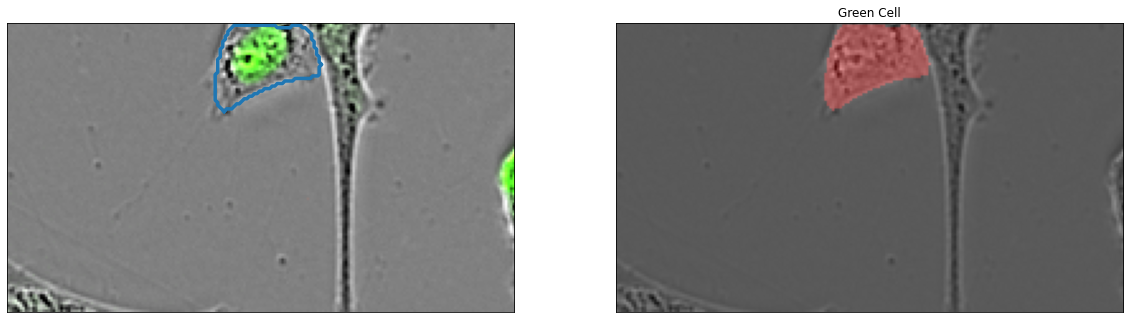

Type in "" (blank) to accept cell or n to reject (type quit to quit or skip to skip images)quit
  maskLabel fluorescence
0         2        green
1         4        green
2         5        green


In [18]:
experiment = 'TJ2201'

# Load information about relevant images
pcDir = os.path.join('../data/',experiment,'phaseContrast')
compositeDir = os.path.join('../data/',experiment,'composite')
labelDir = os.path.join('../data/',experiment,'label')
maskDir = os.path.join('../data/',experiment,'mask')

for path in [pcDir, compositeDir, labelDir, maskDir]:
    assert os.path.isdir(path)

ims = os.listdir(maskDir)
imBases = [cellMorphHelper.getImageBase(im) for im in ims]

# Shuffle so that we get a good range of images
random.seed(1234)
random.shuffle(imBases)

# Begin validation
for imBase in imBases:
    msg = validateImage(imBase, compositeDir, pcDir, maskDir, labelDir)
    if msg == "quit":
        break

In [3]:
experiment = 'TJ2201'

# Load information about relevant images
pcDir = os.path.join('../data/',experiment,'phaseContrast')
compositeDir = os.path.join('../data/',experiment,'composite')
labelDir = os.path.join('../data/',experiment,'label')
maskDir = os.path.join('../data/',experiment,'mask')

for path in [pcDir, compositeDir, labelDir, maskDir]:
    assert os.path.isdir(path)

ims = os.listdir(maskDir)
imBases = [cellMorphHelper.getImageBase(im) for im in ims]


datetime.datetime(2022, 4, 8, 16, 0)

In [7]:
a = ['asdf','asdfgs','asdfasdfasdfasdf', 'as']
a = sorted(a, key=lambda x: len(x), reverse=True)
print(a)

['asdfasdfasdfasdf', 'asdfgs', 'asdf', 'as']
